# Armonk Pulse Expirements

In [27]:
import matplotlib.pyplot as plt 
import numpy as np
from copy import deepcopy

%matplotlib inline
plt.rcParams['font.size'] = 16

import qiskit
from qiskit.ignis.measurement.discriminator.iq_discriminators import \
    LinearIQDiscriminator, QuadraticIQDiscriminator
from qiskit.result.models import ExperimentResultData
from qiskit import IBMQ
import qiskit.tools.jupyter

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

#Set to False to run the discriminator, set to True
#to use pickled data
use_prerun_data = False

qiskit.__qiskit_version__

{'qiskit-terra': '0.11.0',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.4.4',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.14.0'}

In [28]:
account_provider = IBMQ.load_account()
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project

Credentials are already in use. The existing account in the session will be replaced.


In [29]:
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_armonk')
back_config = backend.configuration().to_dict()
device = pulse.PulseChannelSpec.from_backend(backend)

/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [30]:
defaults = backend.defaults()
num_qubits = backend.configuration().n_qubits
# command definition from defaults.
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/pulse/cmd_def.py:66: DeprecationWarning: The CmdDef is being deprecated. All CmdDef methods are now supported by `InstructionScheduleMap` accessible as `backend.defaults().circuit_instruction_map` for any Pulse enabled system.
  DeprecationWarning)


In [31]:
qubits = [0]
schedules = []
meas_buffer = 2
shots = 512
experiment_name = 'X90p'

In [32]:
meas = cmd_def.get('measure', qubits=tuple(range(num_qubits)))

# Create a calibration schedule for the ground state.
schedule_no_pi = pulse.Schedule(name='cal_0')
schedule_no_pi += meas

# Create a calibration schedule for the excited state.
schedule_pi = pulse.Schedule(name='cal_1')
for q in qubits:
    xgate = cmd_def.get('x', qubits=q)
    schedule_pi += xgate

schedule_pi += meas << (schedule_pi.duration + meas_buffer)

# Measurement schedule. Do an X90p gate on both qubits.
schedule_x90p = pulse.Schedule(name=experiment_name)
for q in qubits:
    x90p = cmd_def.get('u3', qubits=q, P0=np.pi/2., P1=0., P2=0.)
    schedule_x90p += x90p
    
schedule_x90p += meas << (schedule_x90p.duration + meas_buffer)
    
schedules = [schedule_no_pi, schedule_pi, schedule_x90p]

/anaconda3/envs/qiskit/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DeprecationWarning: The parameter "channels_to_plot" is being replaced by "channels"
  exec(code_obj, self.user_global_ns, self.user_ns)


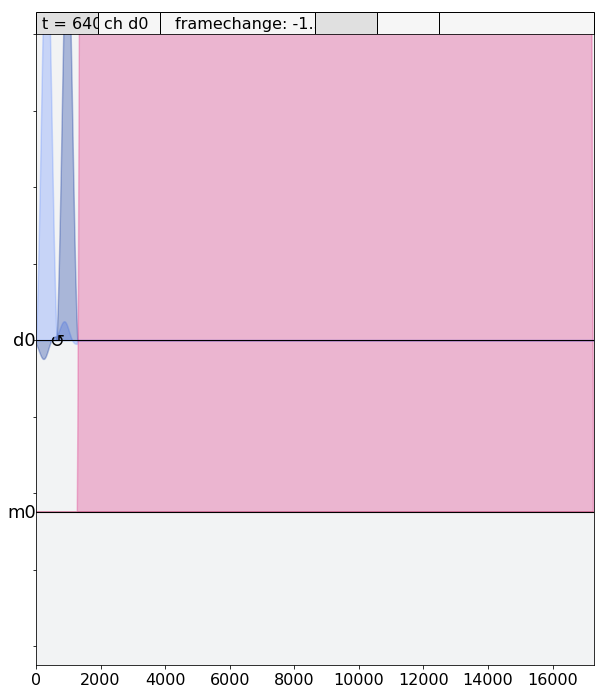

In [33]:
plt_chs = []
for q in range(num_qubits):
    plt_chs.append(device.qubits[q].measure)
    plt_chs.append(device.qubits[q].drive)

schedules[2].draw(channels_to_plot=plt_chs, scaling=10.)

In [34]:
qobj = assemble(schedules, backend, meas_level=1, meas_return='single', shots=shots)

In [35]:
if not use_prerun_data:
    job = backend.run(qobj)
else:
    print('Not running job, will use prerun data')

In [36]:
if not use_prerun_data:
    job.status()
else:
    print('Not running job, will use prerun data')

In [37]:
if use_prerun_data:
    #Use pickle to load existing data
    import pickle
    from qiskit.result import Result

    with open('test_result.pickle', 'rb') as handle:
        res = pickle.load(handle)

    result = Result.from_dict(res)
else:
    result = job.result(timeout=3600)

In [38]:
discriminators = {}

for q in qubits:
    discriminators[q] = LinearIQDiscriminator(result, [q], ['0', '1'])

In [39]:
test_qubit = 0
test_iq_data = [[0.0, 0.0], [0.0, -2.0e11]]
test_states = discriminators[test_qubit].discriminate(test_iq_data)

print('Example results for qubit %i:' % test_qubit)
for idx, iq_point in enumerate(test_iq_data):
    print('IQ point ({:.0f}, {:.0f}) corresponds to state '.format(iq_point[0], iq_point[1]) + test_states[idx])

Example results for qubit 0:
IQ point (0, 0) corresponds to state 0
IQ point (0, -200000000000) corresponds to state 0


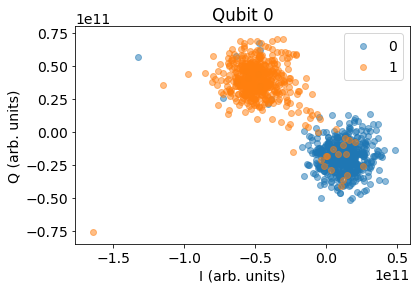

In [40]:
plt.rcParams['font.size'] = 14

discriminators[0].plot();

(array([<matplotlib.axes._subplots.AxesSubplot object at 0x13201bc88>],
       dtype=object), None)

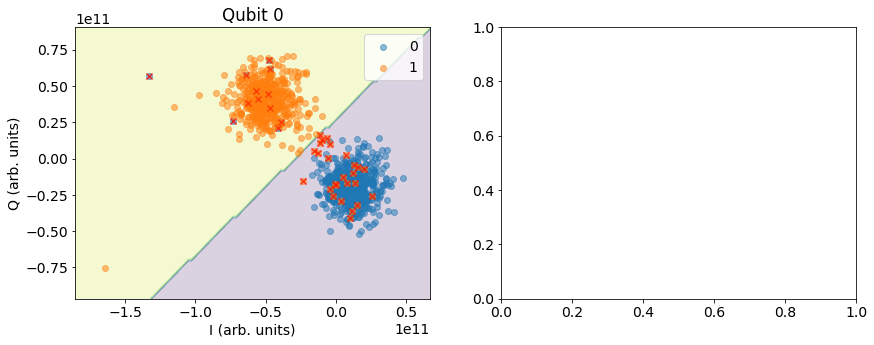

In [47]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

discriminators[0].plot(ax[0], flag_misclassified=True, show_boundary=True)